What if your data is more complex than a straight line? Surprisingly, you can use a linear model to fit nonlinear data. A simple way to do this is to add powers of each feature as new features, then train a linear model on this extended set of features. This technique is called polynomial regression.

Let’s look at an example. First, we’ll generate some nonlinear data, based on a simple quadratic equation—that’s an equation of the form y = ax² + bx + c—plus some noise:

In [ ]:
import numpy as np

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

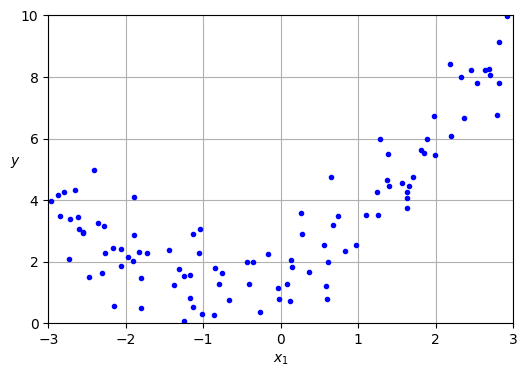

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

Clearly, a straight line will never fit this data properly. So let’s use Scikit-Learn’s PolynomialFeatures class to transform our training data, adding the square (second-degree polynomial) of each feature in the training set as a new feature (in this case there is just one feature):

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
print(X[0])
print(X_poly[0])

[-0.75275929]
[-0.75275929  0.56664654]


X_poly now contains the original feature of X plus the square of this feature. Now we can fit a LinearRegression model to this extended training data.

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

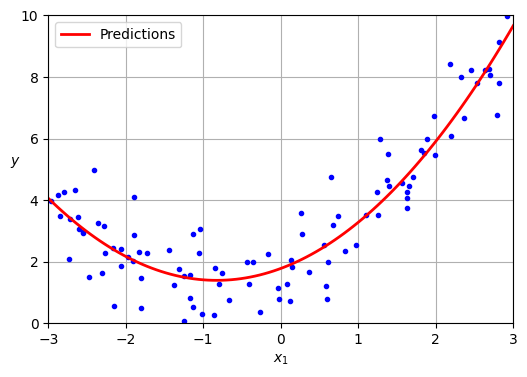

In [ ]:
X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper left")
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

Not bad: the model estimates $ŷ=0.56x_1^2+0.93x_1+1.78$ when in fact the original function was $y=0.5x_1^2+1.0x_1+2.0+ GaussianNoise$

Note that when there are multiple features, polynomial regression is capable of finding relationships between features, which is something a plain linear regression model cannot do. This is made possible by the fact that PolynomialFeatures also adds all combinations of features up to the given degree. For example, if there were two features a and b, PolynomialFeatures with degree=3 would not only add the features $a^2$, $a^3$, $b^2$, and $b^3$, but also the combinations ab, $a^2b$, and $ab^2$.

**Warning:** PolynomialFeatures(degree=d) transforms an array containing n features into an array containing (n + d)! / d!n! features, where n! is the factorial of n, equal to 1 × 2 × 3 × ⋯ × n. Beware of the combinatorial explosion of the number of features!

**Learning Curves**

If you perform high-degree polynomial regression, you will likely fit the training data much better than with plain linear regression. For example, following code/figure applies a 300-degree polynomial model to the preceding training data, and compares the result with a pure linear model and a quadratic model (second-degree polynomial). Notice how the 300-degree polynomial model wiggles around to get as close as possible to the training instances.

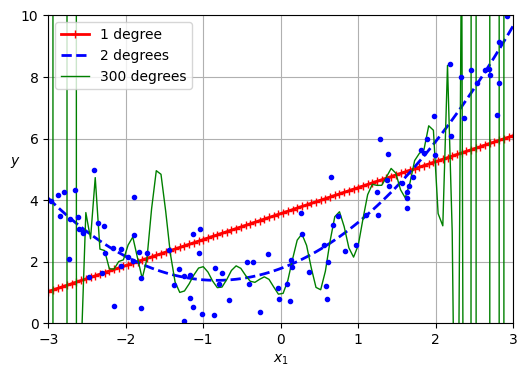

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

plt.figure(figsize=(6, 4))

for style, width, degree in (("r-+", 2, 1), ("b--", 2, 2), ("g-", 1, 300)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = make_pipeline(polybig_features, std_scaler, lin_reg)
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    label = f"{degree} degree{'s' if degree > 1 else ''}"
    plt.plot(X_new, y_newbig, style, label=label, linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

This high-degree polynomial regression model is severely overfitting the training data, while the linear model is underfitting it. The model that will generalize best in this case is the quadratic model, which makes sense because the data was generated using a quadratic model. But in general you won’t know what function generated the data, so how can you decide how complex your model should be? How can you tell that your model is overfitting or underfitting the data?

**Overfitting the Training Data**

Say you are visiting a foreign country and the taxi driver rips you off. You might be tempted to say that all taxi drivers in that country are thieves. Overgeneralizing is something that we humans do all too often, and unfortunately machines can fall into the same trap if we are not careful. In machine learning this is called overfitting: it means that the model performs well on the training data, but it does not generalize well.

Following figure shows an example of a high-degree polynomial life satisfaction model that strongly overfits the training data. Even though it performs much better on the training data than the simple linear model, would you really trust its predictions? <br>
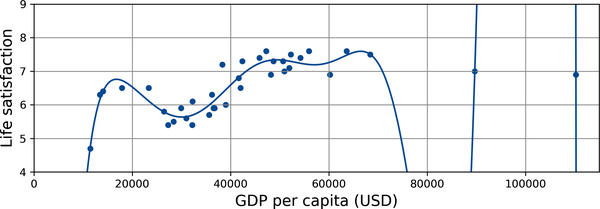

Complex models such as deep neural networks can detect subtle patterns in the data, but if the training set is noisy, or if it is too small, which introduces sampling noise, then the model is likely to detect patterns in the noise itself (as in the taxi driver example). Obviously these patterns will not generalize to new instances. For example, say you feed your life satisfaction model many more attributes, including uninformative ones such as the country’s name. In that case, a complex model may detect patterns like the fact that all countries in the training data with a w in their name have a life satisfaction greater than 7: New Zealand (7.3), Norway (7.6), Sweden (7.3), and Switzerland (7.5). How confident are you that the w-satisfaction rule generalizes to Rwanda or Zimbabwe? Obviously this pattern occurred in the training data by pure chance, but the model has no way to tell whether a pattern is real or simply the result of noise in the data.

Overfitting happens when the model is too complex relative to the amount and noisiness of the training data. Here are possible solutions:


*   Simplify the model by selecting one with fewer parameters (e.g., a linear model rather than a high-degree polynomial model), by reducing the number of attributes in the training data, or by constraining the model.

*   Gather more training data.
*   Reduce the noise in the training data (e.g., fix data errors and remove outliers).



A way to tell is to look at the learning curves, which are plots of the model’s training error and validation error as a function of the training iteration: just evaluate the model at regular intervals during training on both the training set and the validation set, and plot the results. If the model cannot be trained incrementally (i.e., if it does not support partial_fit() or warm_start), then you must train it several times on gradually larger subsets of the training set.

Scikit-Learn has a useful learning_curve() function to help with this: it trains and evaluates the model using cross-validation. By default it retrains the model on growing subsets of the training set, but if the model supports incremental learning you can set exploit_incremental_learning=True when calling learning_curve() and it will train the model incrementally instead. The function returns the training set sizes at which it evaluated the model, and the training and validation scores it measured for each size and for each cross-validation fold. Let’s use this function to look at the learning curves of the plain linear regression model (following figure).

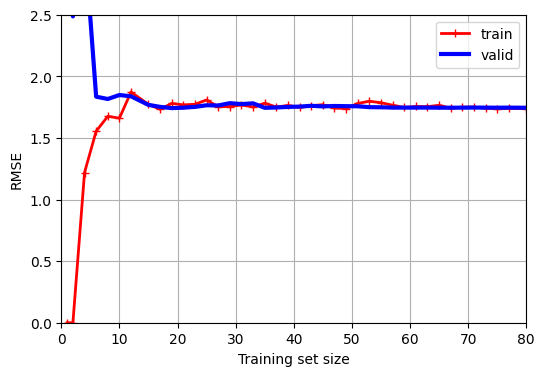

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

# extra code – beautifies and saves Figure 4–15
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0, 80, 0, 2.5])

plt.show()

This model is underfitting. To see why, first let’s look at the training error. When there are just one or two instances in the training set, the model can fit them perfectly, which is why the curve starts at zero. But as new instances are added to the training set, it becomes impossible for the model to fit the training data perfectly, both because the data is noisy and because it is not linear at all. So the error on the training data goes up until it reaches a plateau, at which point adding new instances to the training set doesn’t make the average error much better or worse. Now let’s look at the validation error. When the model is trained on very few training instances, it is incapable of generalizing properly, which is why the validation error is initially quite large. Then, as the model is shown more training examples, it learns, and thus the validation error slowly goes down. However, once again a straight line cannot do a good job of modeling the data, so the error ends up at a plateau, very close to the other curve. <br>
These learning curves are typical of a model that’s underfitting. Both curves have reached a plateau; they are close and fairly high.

**Tip:** If your model is underfitting the training data, adding more training examples will not help. You need to use a better model or come up with better features.

Now let’s look at the learning curves of a 10th-degree polynomial model on the same data (following figure).

In [ ]:
from sklearn.pipeline import make_pipeline

polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression())

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")

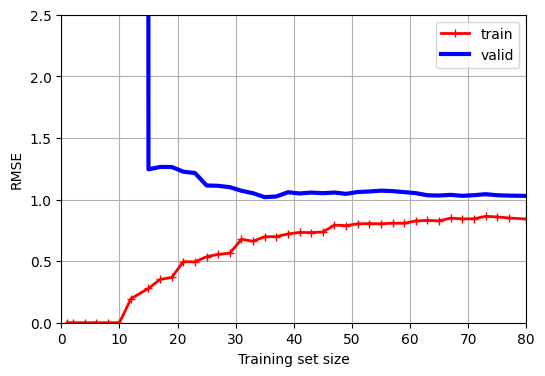

In [ ]:
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.axis([0, 80, 0, 2.5])
plt.show()

These learning curves look a bit like the previous ones, but there are two very important differences:


*   The error on the training data is much lower than before.
*   There is a gap between the curves. This means that the model performs significantly better on the training data than on the validation data, which is the hallmark of an overfitting model. If you used a much larger training set, however, the two curves would continue to get closer.



**Tip:** One way to improve an overfitting model is to feed it more training data until the validation error reaches the training error.

**The bias/variance trade-off**

An important theoretical result of statistics and machine learning is the fact that a model’s generalization error can be expressed as the sum of three very different errors:

**Bias:** This part of the generalization error is due to wrong assumptions, such as assuming that the data is linear when it is actually quadratic. A high-bias model is most likely to underfit the training data.

**Variance:** This part is due to the model’s excessive sensitivity to small variations in the training data. A model with many degrees of freedom (such as a high-degree polynomial model) is likely to have high variance and thus overfit the training data.

**Irreducible error:** This part is due to the noisiness of the data itself. The only way to reduce this part of the error is to clean up the data (e.g., fix the data sources, such as broken sensors, or detect and remove outliers).

Increasing a model’s complexity will typically increase its variance and reduce its bias. Conversely, reducing a model’s complexity increases its bias and reduces its variance. This is why it is called a trade-off.

**Regularized Linear Models**

As you saw in Chapters 1 and 2, a good way to reduce overfitting is to regularize the model (i.e., to constrain it): the fewer degrees of freedom it has, the harder it will be for it to overfit the data. A simple way to regularize a polynomial model is to reduce the number of polynomial degrees.

For a linear model, regularization is typically achieved by constraining the weights of the model. We will now look at ridge regression, lasso regression, and elastic net regression, which implement three different ways to constrain the weights.

**Ridge Regression** <br>
Ridge regression (also called Tikhonov regularization) is a regularized version of linear regression: a regularization term equal to
\begin{align}
\frac{α}{m} \sum_{i=1}^n θ_i^2
\end{align}
is added to the MSE. This forces the learning algorithm to not only fit the data but also keep the model weights as small as possible. Note that the regularization term should only be added to the cost function during training. Once the model is trained, you want to use the unregularized MSE (or the RMSE) to evaluate the model’s performance.

The hyperparameter α controls how much you want to regularize the model. If α = 0, then ridge regression is just linear regression. If α is very large, then all weights end up very close to zero and the result is a flat line going through the data’s mean. Following equation presents the ridge regression cost function. <br>
$J(θ)=MSE(\theta)+\frac{α}{m} \sum_{i=1}^n θ_i^2$

**Warning:** It is important to scale the data (e.g., using a StandardScaler) before performing ridge regression, as it is sensitive to the scale of the input features. This is true of most regularized models.

Following figure shows several ridge models that were trained on some very noisy linear data using different α values. On the left, plain ridge models are used, leading to linear predictions. On the right, the data is first expanded using PolynomialFeatures(degree=10), then it is scaled using a StandardScaler, and finally the ridge models are applied to the resulting features: this is polynomial regression with ridge regularization. Note how increasing α leads to flatter (i.e., less extreme, more reasonable) predictions, thus reducing the model’s variance but increasing its bias. <br>
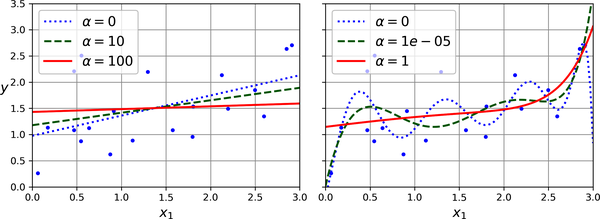

In [ ]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5

In [ ]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=0.1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55325833]])

**Lasso Regression**

Least absolute shrinkage and selection operator regression (usually simply called lasso regression) is another regularized version of linear regression: just like ridge regression, it adds a regularization term to the cost function
$J(θ)=MSE(\theta)+2α \sum_{i=1}^n \mid θ_i \mid$

Following figure shows the same thing as the previous figure but replaces the ridge models with lasso models and uses different α values. <br>
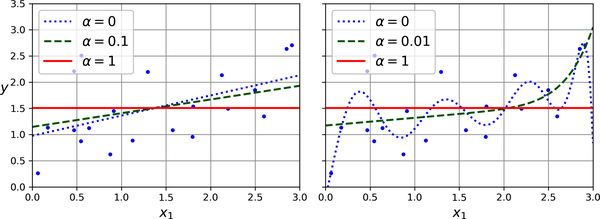

An important characteristic of lasso regression is that it tends to eliminate the weights of the least important features (i.e., set them to zero). For example, the dashed line in the righthand plot in the previous figure (with α = 0.01) looks roughly cubic: all the weights for the high-degree polynomial features are equal to zero. In other words, lasso regression automatically performs feature selection and outputs a sparse model with few nonzero feature weights.

In [ ]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

**Elastic Net Regression**

Elastic net regression is a middle ground between ridge regression and lasso regression. The regularization term is a weighted sum of both ridge and lasso’s regularization terms, and you can control the mix ratio r. When r = 0, elastic net is equivalent to ridge regression, and when r = 1, it is equivalent to lasso regression $J(θ)=MSE(\theta)+r(2α \sum_{i=1}^n \mid θ_i \mid)+(1-r)(\frac{α}{m} \sum_{i=1}^n θ_i^2)$

So when should you use elastic net regression, or ridge, lasso, or plain linear regression (i.e., without any regularization)? It is almost always preferable to have at least a little bit of regularization, so generally you should avoid plain linear regression. Ridge is a good default, but if you suspect that only a few features are useful, you should prefer lasso or elastic net because they tend to reduce the useless features’ weights down to zero, as discussed earlier. In general, elastic net is preferred over lasso because lasso may behave erratically when the number of features is greater than the number of training instances or when several features are strongly correlated.

In [ ]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])